In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm
import pandas as pd

%config Completer.use_jedi = False

In [2]:
## 想辦法剔除掉頭尾相反的圖片


In [3]:
imgspath = r"/home/isis0517/temp_data0/male"
#imgspath = r"/home/isis0517/temp_data0/database"
#imgspath = "/home/isis0517/Documents0/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
flist = [os.path.join(imgspath, path) for path in flist]
data_len = len(flist)//2

data = {
    "num" : np.arange(data_len),
    "side_path" : flist[:data_len],
    "top_path" : flist[data_len:],
}

zebra_df = pd.DataFrame(data)
zebra_df.set_index("num", inplace=True)
print(zebra_df.tail(10))

                                         side_path  \
num                                                  
59990  /home/isis0517/temp_data0/male/c1_59990.npy   
59991  /home/isis0517/temp_data0/male/c1_59991.npy   
59992  /home/isis0517/temp_data0/male/c1_59992.npy   
59993  /home/isis0517/temp_data0/male/c1_59993.npy   
59994  /home/isis0517/temp_data0/male/c1_59994.npy   
59995  /home/isis0517/temp_data0/male/c1_59995.npy   
59996  /home/isis0517/temp_data0/male/c1_59996.npy   
59997  /home/isis0517/temp_data0/male/c1_59997.npy   
59998  /home/isis0517/temp_data0/male/c1_59998.npy   
59999  /home/isis0517/temp_data0/male/c1_59999.npy   

                                          top_path  
num                                                 
59990  /home/isis0517/temp_data0/male/c2_59990.npy  
59991  /home/isis0517/temp_data0/male/c2_59991.npy  
59992  /home/isis0517/temp_data0/male/c2_59992.npy  
59993  /home/isis0517/temp_data0/male/c2_59993.npy  
59994  /home/isis0517/temp_data0/

(400, 1500)


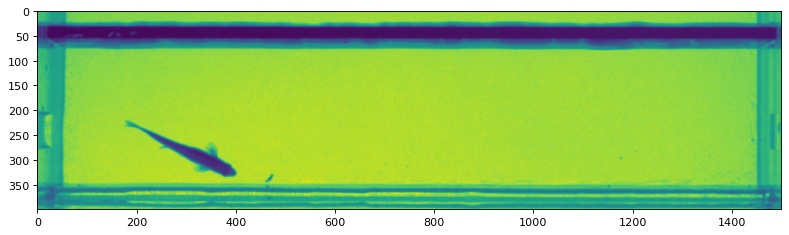

In [4]:
test_frame = np.load(os.path.join(imgspath, flist[8401+data_len]))
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(test_frame)
print(test_frame.shape)

In [5]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
# for s in tqdm(range(data_len)):
    
#     b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
#     b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     a = cv2.resize(a, (1200,400))
#     video.write(np.concatenate((b, a), axis=0))
# video.release()
# plt.imshow(a)


In [6]:
# tnum = np.random.randint(data_len,size = int(data_len*0.2))
# a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
# back = np.zeros(a.shape)
# for s in tnum:
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     back += a
# back = back/len(tnum)
# back = back.astype('uint8')

In [7]:
# video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
# kernel = np.ones((3,3), np.uint8)
# for s in tqdm(range(data_len)):
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
#     diff = cv2.erode(diff, kernel, iterations = 4)
#     diff = cv2.dilate(diff, kernel, iterations = 6)
#     a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
#     video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
# video.release()

    
# diff = cv2.dilate(diff, kernel, iterations = 3)
# plt.imshow(diff)
# #cv2.imwrite("test.png", diff)

In [8]:
# labels = label(diff, connectivity=2, background=0)
# group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [9]:
tnum = np.random.randint(data_len,size = data_len//10)
a = np.load(zebra_df.iloc[0].top_path)
print(a.shape)
background = np.zeros(a.shape)
for path in zebra_df.loc[tnum].top_path:
    a = np.load(path)
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


(400, 1500)


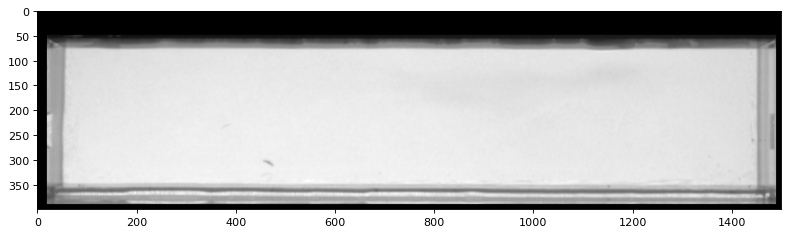

In [10]:
mask = np.full(background.shape, False)
top_bias, top_len = 20, 1470
mask[50:390,top_bias:top_bias+top_len]=True
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(background*mask, plt.cm.gray)

## 轉正圖片 & 儲存

In [11]:
# imgs = []
# h_ans = []

# for s in tqdm(range(data_len)):
    
#     img = np.load(os.path.join(imgspath, flist[s+data_len]))
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         continue
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
    
#     imgs.append(rotated)
#     h_ans.append(angle)

### multi ver

In [12]:
# %%time
# from multiprocessing import Pool
# from numba import jit, njit

# def multi_cle_img(filename, background, mask, abs_lim):
#     img = np.load(filename)
#     img = cv2.absdiff(img, background)
#     img = img*mask
#     img = np.where(img>abs_lim, 255, 0).astype('uint8')
#     pos = get_pos(img)
#     img = cutting_img(img, pos, 100)
#     return img

# map_arr = []

# with Pool() as pool:
#     map_arr = []
#     for s in range(data_len):
#         path = os.path.join(imgspath, flist[s+data_len])
#         map_arr.append((path, background, mask, abs_lim))
#     print("pool start")
#     result = pool.starmap(multi_cle_img, map_arr)
# temp_imgs = result



In [13]:

# def multi_ans(img):
#     try:
#         sk = NT_skeleton(img)
#     except Exception as e:
#         print(s, e)
#         return 0
        
#     v1 = sk[0]-sk[2]
#     a = v1/np.linalg.norm(v1, ord=2)
#     b = np.array([1,0])
#     c = a-b
#     angle = 2*np.arcsin(np.linalg.norm(c/2))
#     if a[1]>0:
#         angle = -angle
#     if angle != angle:
#         print("算錯啦")
#         print(sk)
#     return angle

# with Pool() as pool:
#     print("pool start")
#     result = pool.map(multi_ans, temp_imgs)
# h_ans = result
# print("end")
# imgs = []
# #h_ans = []

# def multi_rot_img(img, angle):
#     M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
#     rotated = cv2.warpAffine(img, M, (201,201))
#     return img

# with Pool() as pool:
#     map_arr = []
#     for s in range(len(h_ans)):
#         map_arr.append((temp_imgs[s], h_ans[s]))
#     print("pool start")
#     result = pool.starmap(multi_rot_img, map_arr)


In [14]:
%%time
from multiprocessing import Pool
from numba import jit, njit

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])


abs_lim = 70
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 120
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    try:
        sk = NT_skeleton(img)
        h_pos = sk[1]+np.array(pos)-np.array([120,120])
    except Exception as e:
        print(s, e)
        return 0
        
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    
    err = b-np.dot(get_rot_M(-angle), a) 
    b_len = np.linalg.norm(b)
    while np.linalg.norm(err) > b_len*0.1:
        angle=-angle
        err = b-np.dot(get_rot_M(-angle), a)
        
    if angle != angle:
        print("算錯啦")
        print(sk)
        
    M = cv2.getRotationMatrix2D((size, size), -angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle, pos, h_pos


with Pool() as pool:
    map_arr = []
    for path in zebra_df.top_path:
        map_arr.append((path, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)

imgs = []
h_ans = []
poses = []
h_poses = []

for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])
    poses.append(temp[2])
    h_poses.append(temp[3])

pool start
CPU times: user 3.38 s, sys: 3.59 s, total: 6.97 s
Wall time: 2min 43s


In [15]:
# 將結果存到 zebra_df裡面

zebra_df["imgs"] = imgs
zebra_df["h_ans"] = h_ans
zebra_df["poses"] = poses
zebra_df["h_poses"] = h_poses

-1.7429871413178357


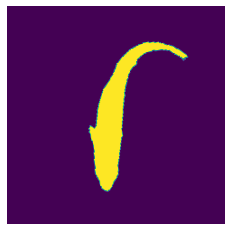

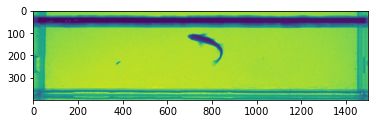

In [16]:
s = 50
sk = NT_skeleton(imgs[s])

print(h_ans[s])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(imgs[s])
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
plt.axis('off')
plt.show()
plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### check速度分布

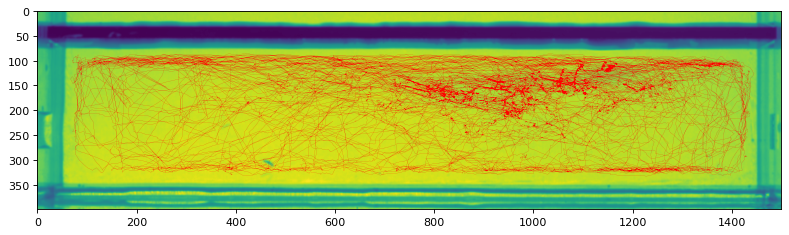

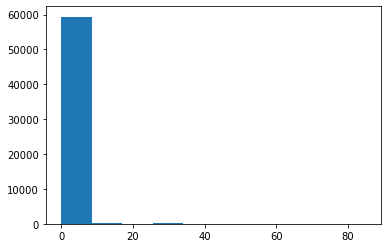

In [17]:
poses = np.array(poses)
h_poses = np.array(h_poses)

plt.figure(figsize=(12, 12), dpi=80)
plt.plot(h_poses[:, 1], h_poses[:, 0], lw = 0.1, c='r')
plt.imshow(background)
plt.show()
velocity = (h_poses[1:]-h_poses[:-1])/2
plt.hist(np.linalg.norm(velocity, axis=1))
plt.show()

In [18]:
last_pos = h_poses[0]
drop_nums = []
for s, pos in enumerate(h_poses):
    if np.linalg.norm(pos-last_pos)>20:
        drop_nums.append(s)
    last_pos = pos

# 重新寫入zebra_df
if len(zebra_df) != data_len-len(drop_nums):
    zebra_df.drop(index=drop_nums, inplace=True)
    zebra_df.reset_index(inplace=True)
zebra_df.tail()

,num,side_path,top_path,imgs,h_ans,poses,h_poses
59565,59995,/home/isis0517/temp_data0/male/c1_59995.npy,/home/isis0517/temp_data0/male/c2_59995.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2.034444,"(171, 531)","[148, 578]"
59566,59996,/home/isis0517/temp_data0/male/c1_59996.npy,/home/isis0517/temp_data0/male/c2_59996.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.975688,"(171, 532)","[146, 582]"
59567,59997,/home/isis0517/temp_data0/male/c1_59997.npy,/home/isis0517/temp_data0/male/c2_59997.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.934775,"(170, 533)","[146, 583]"
59568,59998,/home/isis0517/temp_data0/male/c1_59998.npy,/home/isis0517/temp_data0/male/c2_59998.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.975688,"(170, 534)","[147, 582]"
59569,59999,/home/isis0517/temp_data0/male/c1_59999.npy,/home/isis0517/temp_data0/male/c2_59999.npy,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.951303,"(169, 534)","[147, 582]"


### save as video

In [19]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs[0:1000])):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
zebra_df[["num", "imgs"]].to_numpy()

array([[0,
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
       [1,
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
       [2,
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
       ...,
       [59997,
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
       [59998,
        array

# apply the eigenfish(PCA)

## 找出新的 sk

In [21]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)


han_sks=[]

for s, img in zebra_df[["num", "imgs"]].to_numpy():
    
    sk = NT_skeleton(img, er_num=2, di_num=3)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print("sk error")
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        break
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
            break
        err = b-np.dot(get_rot_M(angle), a)
        b_len = np.linalg.norm(b)
        while np.linalg.norm(err) > b_len*0.1:
            angle=-angle
            err = b-np.dot(get_rot_M(angle), a)
        
        han_sk.append(angle)
    han_sks.append(np.array(han_sk))
print(len(han_sks))    

## 20000張 1:25

59570


In [22]:
## 新增到zebra_df

zebra_df['han_sks'] = han_sks


In [23]:
print(type(han_sks))
temp = [sk for sk in zebra_df.han_sks.to_numpy()]
print(temp[0:10])

<class 'list'>
[array([0.0475831, 0.0475831, 0.0499584, 0.       , 0.0499584, 0.0475831,
       0.       , 0.0499584]), array([ 0.0475831 ,  0.        ,  0.0475831 ,  0.0475831 ,  0.0475831 ,
        0.0475831 ,  0.0499584 , -0.05258306]), array([0.0475831 , 0.13552771, 0.19739556, 0.29145679, 0.29145679,
       0.33667482, 0.24497866, 0.14888995]), array([0.09065989, 0.12970254, 0.32175055, 0.36397896, 0.5404195 ,
       0.60005021, 0.52479577, 0.38050638]), array([0.        , 0.14189705, 0.13552771, 0.18822151, 0.38050638,
       0.5485494 , 0.84781697, 1.10714872]), array([0.        , 0.09065989, 0.08673834, 0.13552771, 0.09065989,
       0.27829966, 0.62548504, 0.9179497 ]), array([0.04542328, 0.09495171, 0.09495171, 0.14189705, 0.09065989,
       0.14189705, 0.33667482, 0.53172407]), array([0.0499584 , 0.09966865, 0.14189705, 0.09065989, 0.14189705,
       0.14888995, 0.29145679, 0.37089129]), array([-0.09516621,  0.        ,  0.0473686 ,  0.0473686 ,  0.        ,
        0.101306

In [24]:
%%script false --no-raise-error
import skimage 
def NT_skeleton_t(img, **kwargs):
    """

    :param img: the img of the zebrafish, it must be uint8 with 1 channel img
    :kwargs
        er_num: the number of iteration for erode.
        di_num: the number of iteration for dilate.
        sk_num: the number of node in skeleton.
    :return sk: The skeleton of fish
    """

    sk_num = kwargs.setdefault('sk_num', 10)
    ekernel = np.array([[0, 1, 0],
                        [1, 0, 1],
                        [0, 1, 0]], dtype='uint8')
    assert img.dtype == 'uint8' or img.dtype == np.uint8, "it is not uint8"

    img = pre_img(img, **kwargs)
    labels = skimage.measure.label(img, connectivity=1, background=0)
    group = regionprops(labels, cache=True)

    n, index = 0, 0
    area = 0
    for com in group:
        if com.area > area:
            index = n
            area = com.area
    com = group[index]

    # the minimums box contain all points of the img
    min_row, min_col, max_row, max_col = com.bbox
    # sub = img[min_row:max_row, min_col:max_col]

    min_row = min_row - 2
    min_col = min_col - 2
    max_row = max_row + 2
    max_col = max_col + 2

    # sub = np.pad(sub,((2,2),(2,2)),'constant',constant_values = (0,0))

    # the minimums box's size
    row, col = (max_row - min_row, max_col - min_col)
    points = com.coords - np.array([min_row, min_col])

    sub = np.zeros((row, col), dtype=np.uint8)
    sub[points[:, 0], points[:, 1]] = 255
    # cut to smallest size
    erosion = cv2.erode(sub, ekernel, iterations=1)
    height = cv2.distanceTransform(erosion, cv2.DIST_L2, 3)[points[:, 0], points[:, 1]]

    not_known = erosion > 100
    is_bound = np.logical_xor(erosion, sub)

    # points

    points_ord = np.argsort(height)

    U, count = find_U(is_bound, points[points_ord], not_known)  # 0.3ms

    result = find_cen(U, count)  # 1ms
    result = result * (erosion > 100)
    
    labels = skimage.measure.label(result, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        print(com.area)
        if com.area > area:
            index = com.label
            area = com.area
    result = labels==index
    
    point = np.nonzero(result)
    point = list(zip(point[0], point[1]))

    skeleton = find_ske(result, point, sub, sim_num=sk_num) + np.array([min_row, min_col])

    return skeleton


In [25]:
%%script false --no-raise-error
s = 50   
img = pre_img(imgs[s])
sk = NT_skeleton_t(imgs[s], er_num=2, di_num=3)
print(sk)
draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

## find the pca

[0.85445098 0.09043393 0.02239653] 0.9672814506329379


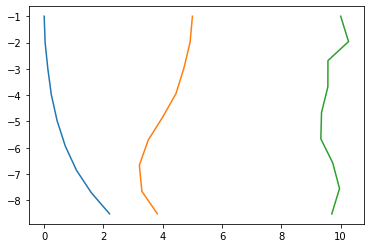

In [26]:
import pickle as pk
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
          
temp = [sk for sk in zebra_df.han_sks.to_numpy()]
pca.fit(temp)
          
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)
with open("sideview_pca.pkl", "wb") as file: 
    pk.dump(pca, file)

In [27]:
## add to the zebra_df
zebra_df["pca_sks"] = [sk for sk in pca_sks]

# apply the Kmeans

In [28]:
from sklearn.cluster import KMeans

n_clusters = 23
pos_kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=40)
pos_kmeans.fit(pca_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

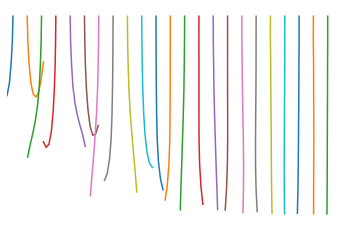

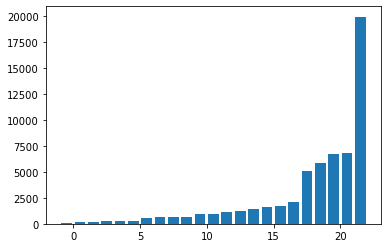

205


In [29]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()
print(nums[ords[2]])

0


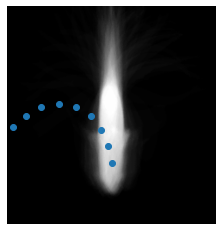

1


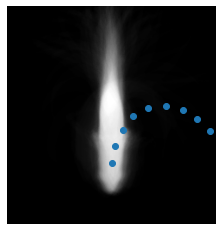

2


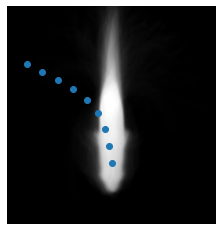

3


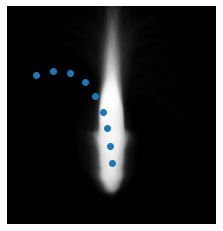

4


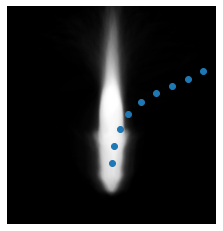

5


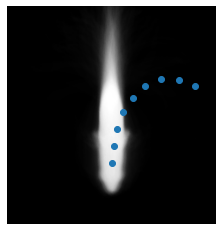

6


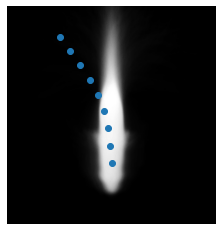

7


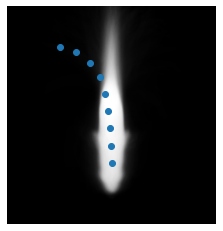

8


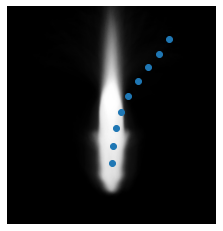

9


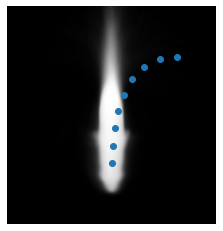

10


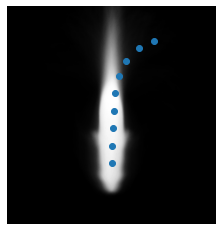

11


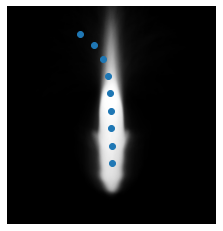

12


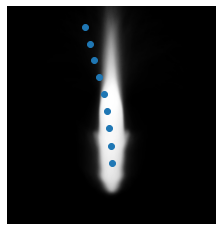

13


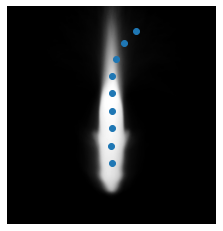

14


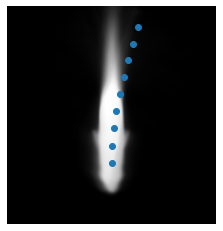

15


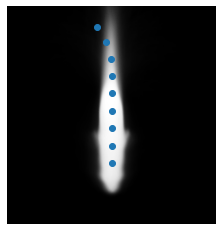

16


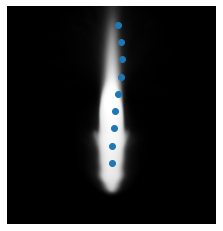

17


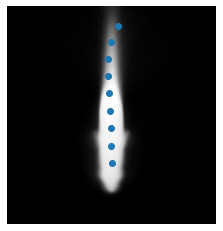

18


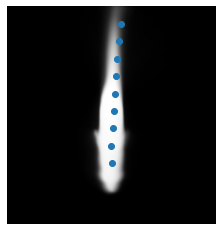

19


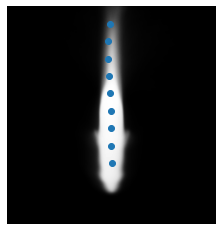

20


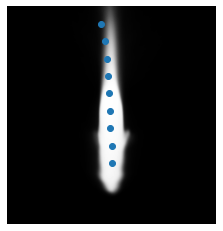

21


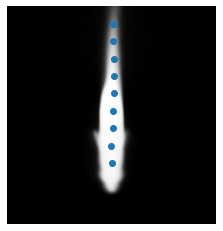

22


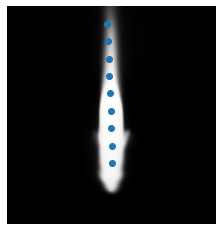

In [30]:
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -5, 20])
    
    sks = np.dot(pos_kmeans.cluster_centers_[ords[s]], pca.components_)
    sk = [np.array([0,2])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    
    plt.scatter(sk[:, 0], sk[:, 1])
    
    plt.axis('off')
    plt.show()

In [31]:
_, bins = np.histogram(np.abs(h_ans))
dic_ans = np.digitize(np.abs(h_ans), bins)

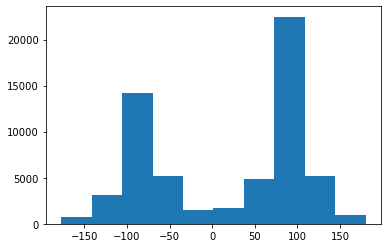

In [32]:
_ = plt.hist(np.array(h_ans)/np.pi*180)

In [33]:
# 用 pca + angle 做kmeans

In [34]:
[ an for an in zebra_df["h_ans"].to_numpy()]

[2.356194490192345,
 2.323947607757091,
 2.1341125882868646,
 1.9756881130799797,
 1.837048375945822,
 1.8545904360032246,
 1.8259787174157147,
 1.7942729279355296,
 1.837048375945822,
 1.804539507663798,
 1.837048375945822,
 1.849095985800008,
 1.849095985800008,
 1.849095985800008,
 1.849095985800008,
 1.804539507663798,
 1.804539507663798,
 1.804539507663798,
 1.804539507663798,
 1.7942729279355296,
 1.7590178320996672,
 1.6162196062164738,
 1.6162196062164738,
 1.5707963267948968,
 1.5707963267948968,
 1.6183794300718801,
 1.6162196062164738,
 1.6162196062164738,
 1.6162196062164738,
 1.6183794300718801,
 1.6162196062164738,
 1.6162196062164738,
 1.5707963267948968,
 1.6162196062164738,
 1.6183794300718801,
 1.5707963267948968,
 1.6183794300718801,
 1.6183794300718801,
 1.6183794300718801,
 1.6162196062164738,
 1.6183794300718801,
 1.5707963267948968,
 1.7126933813990604,
 1.9074711461816238,
 2.293775680196387,
 3.094009550312813,
 -1.695151321341658,
 -1.7004988639508087,
 -1.742

In [35]:
%%time
from sklearn.cluster import KMeans
h_ans = [180*an/np.pi for an in zebra_df["h_ans"].to_numpy()]
merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
n_clusters = 170
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr)
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_

CPU times: user 1min 10s, sys: 1min 18s, total: 2min 29s
Wall time: 18.8 s


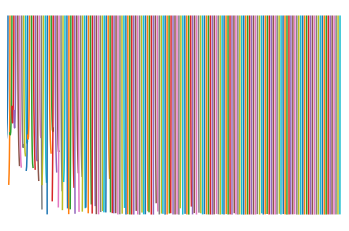

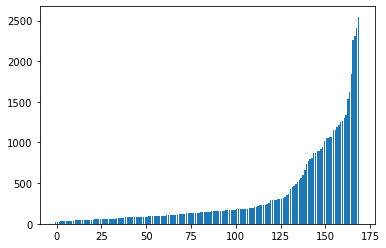

Text(0.5, 0, 'angle')

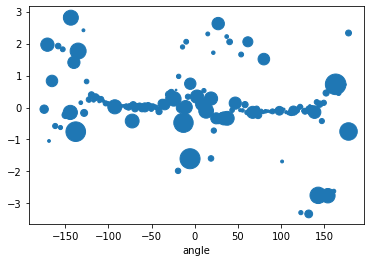

In [36]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

## clean up the kmeans

In [37]:
## groups by labels
groups = []
for n in range(kmeans.n_clusters):
    groups.append([])
    
for num, label in enumerate(labels):
    groups[label].append(num)

In [38]:
s = 0
sel_nums = []
for group in groups:
    s += len(group)
    if not len(group) < np.power(data_len, 0.4):
        sel_nums.extend(group)
print(len(sel_nums),  np.power(data_len, 0.4))

57164 81.51931096059229


In [39]:
%%time
from sklearn.cluster import KMeans

merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=20)
kmeans.fit(merge_arr[sel_nums])
labels = kmeans.predict(merge_arr)
centers = kmeans.cluster_centers_

CPU times: user 1min 20s, sys: 1min 30s, total: 2min 51s
Wall time: 21.6 s


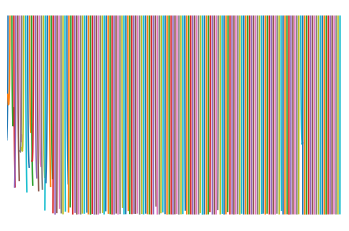

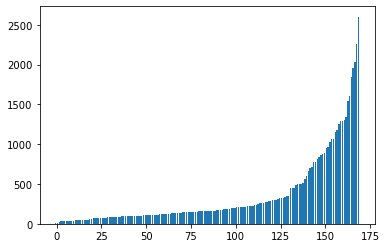

Text(0.5, 0, 'angle')

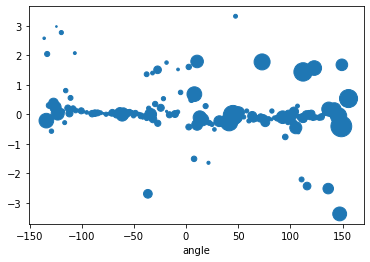

In [40]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas[1:], pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1

plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

plt.scatter(*centers[ords][:,0:2].T, marker="o", s=nums/6)
plt.xlabel("angle")

# 產生對應的side view

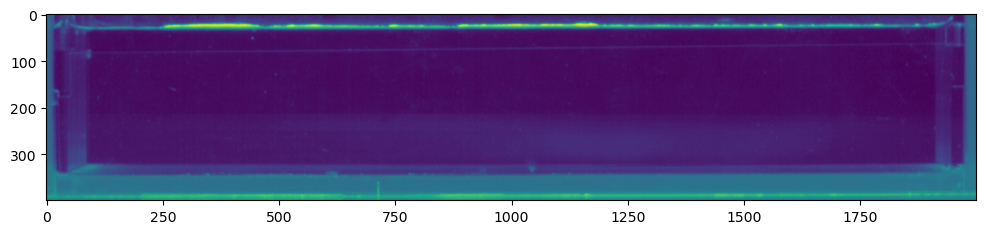

In [41]:
tnum = np.random.randint(len(zebra_df),size = int(data_len*0.1))
a = np.load(zebra_df['side_path'][0])
side_back = np.zeros(a.shape)
for path in zebra_df.loc[tnum].side_path:
    a = np.load(path)
    a = cv2.cvtColor(a, cv2.COLOR_BAYER_BG2GRAY)
    a = cv2.blur(a, ksize=(3, 3))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)


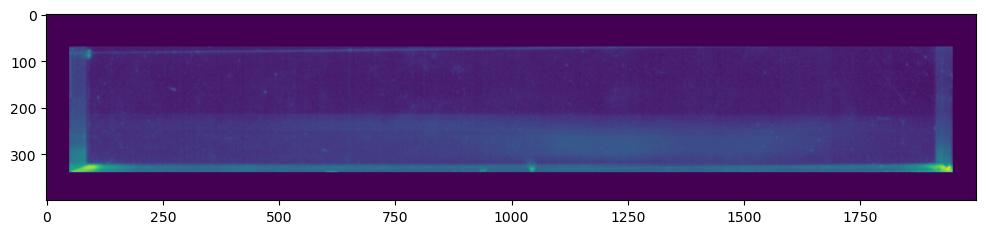

In [42]:

side_bias, side_len = 50, 1900
plt.figure(figsize=(12,8), dpi= 100)

aq_mask = np.full(a.shape, False)
aq_mask[70:340, side_bias:side_bias+side_len]= True
plt.imshow((side_back*aq_mask))
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')

-0.6


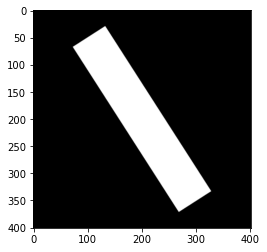

In [43]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (20, 165), (380, 235), (255,255,255), -1)
M = cv2.getRotationMatrix2D((200, 200), (1)/(np.pi)*180, 1)
rotated = cv2.warpAffine(stand, M, (401,401))
stands = []
rot_an = []
level_lim = 50
for s in range(level_lim):
    an = (-1+(2*s/level_lim))
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    stands.append(cv2.warpAffine(stand, M, (401,401)))
    rot_an.append(an)
plt.imshow(stands[10])
print(rot_an[10])

M = cv2.getRotationMatrix2D((200, 200), -rot_an[0]/(np.pi)*180, 1)
plt.imshow(cv2.warpAffine(stands[0], M, (401,401)))
plt.imshow(stands[0])

In [44]:
# sideviews = []
# kernel = np.ones((3,3), np.uint8)
    
# for s in tqdm(range(data_len)):
#     raw = np.load(os.path.join(imgspath, flist[s]))
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
#     diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
#     diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
#     diff = cv2.erode(diff, kernel, iterations = 7)
#     diff = cv2.dilate(diff, kernel, iterations = 10)
    
#     a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
#     side = cv2.bitwise_and(a, a, mask = diff)#apply mask
#     img = cutting_img(side, get_pos(diff), size = 200)
    
#     bacis = []
#     for num, stand in enumerate(stands):
#         bacis.append(np.sum(np.logical_and(img ,stand)))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))

#     sideviews.append(img)
    

# #cv2.imwrite("test.png", diff)

## multi ver

In [45]:

from multiprocessing import Pool
from numba import jit, njit

# pure the img and caculate the score

@jit(nogil=True)
def muti_img(filepath, top_pos, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an, side_back=side_back,
             top_bias=top_bias, top_len=top_len, side_len=side_len, side_bias=side_bias):
    

    score = 0    
    raw = np.load(filepath)
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>25)*255).astype('uint8')
    diff = cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    diff = cv2.erode(diff, kernel, iterations = 3)
    diff = cv2.dilate(diff, kernel, iterations = 2)
    
    side_pos = get_pos(diff)
    pos_ratio = (top_pos[1]-top_bias)/top_len
    pos = (side_pos[0], int(pos_ratio*side_len+side_bias))
    
    a = cv2.cvtColor(raw, cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, pos, size = 200)
    diff = cutting_img(diff, pos, size = 200)
    
    bacis = [0]*len(stands)
    for num, stand in enumerate(stands):
        bacis[num] = np.sum(np.logical_and(img ,stand))
    bigarg = np.argmax(bacis)
    
    an = -rot_an[bigarg]
    M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
    if bacis[bigarg] > 20000:
        img = cv2.warpAffine(img, M, (401,401))
    
    score = np.sum(diff)*0.5+ bacis[bigarg]
    
#     bacis = [0]*len(stands)
#     for num, stand in enumerate(stands):
#         bacis[num] = np.sum(np.logical_and(img ,stand))
#     bigarg = np.argmax(bacis)
#     an = -rot_an[bigarg]
#     M = cv2.getRotationMatrix2D((200, 200), an/(np.pi)*180, 1)
#     img = cv2.warpAffine(img, M, (401,401))
    
    return img, score, diff

with Pool() as pool:
    map_arr = []
    for pos, path in zebra_df[["poses","side_path"]].to_numpy():
        map_arr.append((path, pos))
    print("pool start")
    result = pool.starmap(muti_img, map_arr, chunksize=20)
    
sideviews = []
sidescores = []
for img, s, diff in result:
    sideviews.append(img)
    sidescores.append(s)
sidearea = np.array(sidescores)

sidearea = sidearea/max(sidearea)
del result

<ipython-input-45-e9a3d616bed0>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'get_pos': Cannot determine Numba type of <class 'function'>

File "<ipython-input-45-e9a3d616bed0>", line 19:
def muti_img(filepath, top_pos, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an, side_back=side_back,
    <source elided>
    
    side_pos = get_pos(diff)
    ^

  @jit(nogil=True)


pool start


<ipython-input-45-e9a3d616bed0>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'get_pos': Cannot determine Numba type of <class 'function'>

File "<ipython-input-45-e9a3d616bed0>", line 19:
def muti_img(filepath, top_pos, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an, side_back=side_back,
    <source elided>
    
    side_pos = get_pos(diff)
    ^

  @jit(nogil=True)
<ipython-input-45-e9a3d616bed0>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "muti_img" failed type inference due to: Untyped global name 'get_pos': Cannot determine Numba type of <class 'function'>

File "<ipython-input-45-e9a3d616bed0>", line 19:
def muti_img(filepath, top_pos, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an, side_back=side_back,
    <source elided>
    
    side_pos = get_po

<ipython-input-45-e9a3d616bed0>:6: NumbaWarning: Code running in object mode won't allow parallel execution despite nogil=True.
  @jit(nogil=True)
/home/isis0517/anaconda3/envs/zebra/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "muti_img" was compiled in object mode without forceobj=True.

File "<ipython-input-45-e9a3d616bed0>", line 7:
@jit(nogil=True)
def muti_img(filepath, top_pos, mask=aq_mask, stands=stands, kernel=np.ones((3,3), np.uint8), rot_an=rot_an, side_back=side_back,
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/isis0517/anaconda3/envs/zebra/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

Fil

In [47]:
zebra_df["siedimgs"] = sideviews
zebra_df["sidearea"] = sidearea

59570


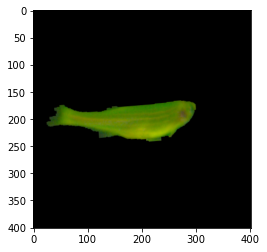

<bound method DataFrame.memory_usage of          num                                    side_path  \
0          0      /home/isis0517/temp_data0/male/c1_0.npy   
1          1      /home/isis0517/temp_data0/male/c1_1.npy   
2          2      /home/isis0517/temp_data0/male/c1_2.npy   
3          3      /home/isis0517/temp_data0/male/c1_3.npy   
4          4      /home/isis0517/temp_data0/male/c1_4.npy   
...      ...                                          ...   
59565  59995  /home/isis0517/temp_data0/male/c1_59995.npy   
59566  59996  /home/isis0517/temp_data0/male/c1_59996.npy   
59567  59997  /home/isis0517/temp_data0/male/c1_59997.npy   
59568  59998  /home/isis0517/temp_data0/male/c1_59998.npy   
59569  59999  /home/isis0517/temp_data0/male/c1_59999.npy   

                                          top_path  \
0          /home/isis0517/temp_data0/male/c2_0.npy   
1          /home/isis0517/temp_data0/male/c2_1.npy   
2          /home/isis0517/temp_data0/male/c2_2.npy   
3          

In [49]:

print(len(sideviews))
img = sideviews[44]

plt.imshow(img[:,:,::-1])
plt.show()

#np.savez("0421-sideviews.npz", sideviews)

59570


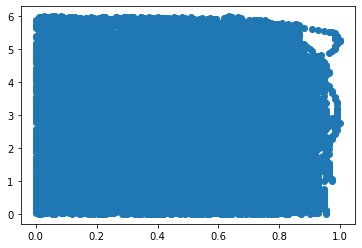

In [62]:
## 評分標準增加魚的位置，越中間越好\
temp_x, temp_y = [], []
poses = [pos for pos in zebra_df["poses"].to_numpy()]
for x, y in poses:
    temp_x.append(x)
    temp_y.append(y)
centrail = [(max(temp_x)+min(temp_x))/2, (max(temp_y)+min(temp_y))/2]
top_rect = [(max(temp_x)-min(temp_x)), (max(temp_y)-min(temp_y))]
temp_dis = np.array(poses)-np.array(centrail)
temp_dis = np.abs(temp_dis)
temp_dis = temp_dis/np.max(temp_dis[:,0], axis=0)
plt.scatter(*temp_dis.T)
#print(temp_dis[:10])
#print((1-temp_dis**8)[:10])
#print((np.sum(1-temp_dis**6, axis=1))[0:10])

print(len(temp_x))
sidescores = sidearea*0 + np.sum(1-temp_dis**9, axis=1)


In [63]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
#             print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper+1)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
            #print(upper, lower)
        return self.ords[lower]
                    
            

# 用 sideview 對應出各個 kmeans center

In [64]:
#%%time
merge_arr = np.concatenate((np.expand_dims(h_ans, axis=1), pca_sks), axis=1)

cen_inds = []

cen_set =  {s:[] for s in range(n_clusters)}
    
for s, label in enumerate(labels):
    cen = centers[label]
    arr = merge_arr[s]
    dis = np.linalg.norm(arr-cen)
    score = sidescores[s]
    cen_set[label].append((s, score))
    
for s in range(n_clusters):
    cen_set[s].sort(key=lambda x: x[1])
    
cen_inds = [cen_set[s][0][0] for s in range(n_clusters)]
print(cen_inds[:10])
#ind = 177

class ImgGetor:
    def __init__(self, cen_set, B=1):
        
        for s in range(len(cen_set)):
            cen_set[s].sort(key=lambda x: x[1])
        self.cen_set = cen_set.copy()
        self.cen_probs = []
        self.cen_Qs = []
        for sett in self.cen_set.values():
            Q = 0
            #print(sett)
            length = 10 if len(sett) > 10 else len(sett)
            probs = []
            for s in range(length):
                P = np.exp(-B*(sett[s][1]))
                Q += P
                
                probs.append((sett[s][0], P))
            self.cen_probs.append(probs)
            self.cen_Qs.append(Q)
    
    def label2img(self, label, rat=1):
        if rat>=1 or rat<0:
            #print("error")
            rat = rat=np.random.rand()
        #print(rat)
        rat = rat*self.cen_Qs[label]
        CP = 0
        for s in self.cen_probs[label]:
            CP += s[1]
            ind = s[0]
            
            if CP > rat:
                break
        #print(self.cen_probs[label])
        return ind
        
geter = ImgGetor(cen_set, B=120)
print(geter.label2img(1))

[59156, 22054, 54998, 58870, 21854, 21142, 23644, 59146, 17355, 22106]
56647


<ipython-input-64-3e5c193c901d>:36: RuntimeWarning: overflow encountered in exp
  P = np.exp(-B*(sett[s][1]))


In [65]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for label in tqdm(labels[20000:30000]):
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

  0%|          | 0/10000 [00:00<?, ?it/s]

# load the other vidoe

this data is hard to get the posture 

In [ ]:
path2 = r"/media/isis0517/QVO2/0419/FaMb1/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[-20:])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a, plt.cm.gray)

In [ ]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.1))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    a = cv2.blur(a, ksize=(3, 3))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

In [ ]:
new_mask = np.full(new_background.shape, False)
new_mask[:255, 75:] = True
plt.imshow(new_background*new_mask)

In [ ]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)

new_imgs = []
new_h_ans = []
new_poses = []
new_han_sks = []
for filename in tqdm(flist2[:]):
    img = np.load(os.path.join(path2, filename))
    img = cv2.absdiff(new_background, img)*new_mask
    img = np.where(img>80, 255, 0).astype('uint8')
    pos = get_pos(img)
    new_poses.append(pos)
    img = cutting_img(img, pos, 150)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1, 0]) # this is the baseline vector
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    
    if angle != angle:
        print("算錯啦")
        print(sk)
        
    err = b-np.dot(get_rot_M(-angle), a) 
    b_len = np.linalg.norm(b)
    while np.linalg.norm(err) > b_len*0.1:
        angle=-angle
        err = b-np.dot(get_rot_M(-angle), a)
        
    M = cv2.getRotationMatrix2D((size, size), -angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
        
    h_an = angle
    M = cv2.getRotationMatrix2D((150, 150), -angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (301,301))
    
    try:
        sk = NT_skeleton(rotated)
    except Exception as e:
        print(s, e)
        continue
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(filename, vec_sk)
            draw = img.copy()
            cv2.circle(draw, (sk[0, 1], sk[0, 0]), 2, (0), -1)
            for n in range(len(sk)-1):
                cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
            plt.imshow(draw)
            plt.show()
            continue
            
        err = b-np.dot(get_rot_M(angle), a)
        b_len = np.linalg.norm(b)
        while np.linalg.norm(err) > b_len*0.1:
            angle=-angle
            err = b-np.dot(get_rot_M(angle), a)
        
        han_sk.append(angle)   
    new_h_ans.append(h_an)
    new_imgs.append(rotated)
    new_han_sks.append(han_sk)
    
    
plt.imshow(imgs[120])

In [ ]:
## show specific img
s = 11603
img = np.load(os.path.join(path2, flist2[s]))
img = cv2.absdiff(new_background, img)
img = np.where(img>60, 255, 0).astype('uint8')
pos = get_pos(img)
new_poses.append(pos)
img = cutting_img(img, pos, 150)
sk = NT_skeleton(img, er_num=5, di_num=4)

draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    
vec_sk = []
for i in range(len(sk)-1):
    vec_sk.append(sk[i+1]-sk[i])

heading = vec_sk[0]
han_sk=[]

heading = heading/np.linalg.norm(heading)
for vec in vec_sk[1:]:
    vec = vec/np.linalg.norm(vec)
    a = heading
    b = vec

    #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if angle != angle:
        print("算錯啦")
        print(filename, vec_sk)
        draw = imgs.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        continue
    err = a-np.dot(b, get_rot_M(angle))
    if np.linalg.norm(err) > 0.1:
        #print("turning", a, np.dot(b, get_rot_M(-angle)))
        angle=-angle
    han_sk.append(angle)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))


In [ ]:
from sklearn.decomposition import PCA
new_pca = PCA(n_components=3)
new_pca.fit(new_han_sks)
pc1 = new_pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in new_pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(new_pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = new_pca.transform(new_han_sks)

In [ ]:
s = 2981
img = np.load(os.path.join(path2, flist2[s]))
plt.imshow(img*new_mask)

## generate the origin(database, no interact) path

In [ ]:
#%%time

## setting the video config
LCD_size = (1280, 2000)
video = cv2.VideoWriter("output_ori.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 20,
                        LCD_size)

vidoe_back = np.full((LCD_size[1], LCD_size[0], 3), 255, dtype='uint8')

## setting back config
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
lcd_ratio = 872/back.shape[1]
geter = ImgGetor(cen_set, B=6000)

for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
rand_ints = np.random.rand(100000)
for s, label in enumerate(tqdm(labels[0:10000])):
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    pos = (200,poses[s][1])
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    img = cv2.resize(img, (int(back.shape[1]*lcd_ratio), int(back.shape[0]*lcd_ratio)))
    shape = img.shape
    temp = vidoe_back.copy()
    temp[:shape[0], 200: 200+shape[1], ...] = img
    video.write(temp)
    video_poses.append(pos)
    
for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
video.release()
np.save("ori_poses", video_poses)

### use new method

In [ ]:
#%%time

## setting the video config
LCD_size = (1280, 2000)
video = cv2.VideoWriter("output_ori.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 20,
                        LCD_size)

vidoe_back = np.full((LCD_size[1], LCD_size[0], 3), 255, dtype='uint8')

## setting back config
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
lcd_ratio = 872/back.shape[1]
geter = ImgGetor(cen_set, B=6000)

for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
rand_ints = np.random.rand(100000)
for s, label in enumerate(tqdm(labels[0:10000])):
    ind = geter.label2img(label)
    img = sideviews[ind].copy()
    pos = (200,poses[s][1])
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    img = cv2.resize(img, (int(back.shape[1]*lcd_ratio), int(back.shape[0]*lcd_ratio)))
    shape = img.shape
    temp = vidoe_back.copy()
    temp[:shape[0], 200: 200+shape[1], ...] = img
    video.write(temp)
    video_poses.append(pos)
    
for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
video.release()
np.save("ori_poses", video_poses)

## Adding the start singal with larger size

In [ ]:
#%%time
new_pca_sks = pca.transform(new_han_sks)
new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0]*5, side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

## setting the video config
LCD_size = (1280, 2000)
video = cv2.VideoWriter("output_rob.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30,
                        LCD_size)

vidoe_back = np.full((LCD_size[1], LCD_size[0], 3), 255, dtype='uint8')

## setting back config
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
lcd_ratio = 872/back.shape[1]
geter = ImgGetor(cen_set, B=6000)

for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []

rand_ints = np.random.rand(len(new_labels))
for s, label in enumerate(tqdm(new_labels)):
    ind = geter.label2img(label, rat=rand_ints[s])
    img = sideviews[ind].copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = glue_img(img, pos, back)
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    img = cv2.resize(img, (int(back.shape[1]*lcd_ratio), int(back.shape[0]*lcd_ratio)))
    shape = img.shape
    temp = vidoe_back.copy()
    temp[:shape[0], 200: 200+shape[1], ...] = img
    video.write(temp)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("rob_poses", video_poses)
print(len(set(new_labels)))

In [ ]:
#%%time
new_pca_sks = pca.transform(new_han_sks)
new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
new_labels = kmeans.predict(new_merge_arr)
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
geter = ImgGetor(cen_set, B=6000)

video = cv2.VideoWriter("output_rob.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30,
                        (back.shape[1], back.shape[0]))


rand_ints = np.random.rand(len(new_labels))
for s, label in enumerate(tqdm(new_labels)):
    ind = geter.label2img(label, rat=rand_ints[s])
    img = sideviews[ind].copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = glue_img(img, pos, back)
    video.write(img)
video.release()

### new method

In [ ]:
# generate the label
new_pca_sks = pca.transform(new_han_sks)
new_pos_labels = pos_kmeans.predict(new_pca_sks)
new_an_labels = np.digitize(new_h_ans, an_bins)-1

nums, bins = np.histogram(new_pos_labels, bins=np.arange(pos_kmeans.n_clusters+1)-0.5)

plt.bar(bins[:-1], nums[ords])

In [ ]:
video = cv2.VideoWriter("output_new_rob.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30,
                        (side_back.shape[1], side_back.shape[0]))

back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')

for s in tqdm(range(len(new_an_labels))):
    label = (new_pos_labels[s], new_an_labels[s])
    if label not in set(merge_labels):
        label = (new_pos_labels[s-1], new_an_labels[s-1])
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*back.shape[1]//10*8 + 100 ))
    img = merge_label2sideviews[label]
    img = glue_img(img, pos, back)
    video.write(img)
video.release()

## red dot ver

In [ ]:
#%%time
#new_pca_sks = pca.transform(new_han_sks)
#new_merge_arr = np.concatenate((np.expand_dims(new_h_ans, axis=1), new_pca_sks), axis=1)
#new_labels = kmeans.predict(new_merge_arr)
#geter = ImgGetor(cen_set, B=6000)

## setting the video config
LCD_size = (1280, 2000)
video = cv2.VideoWriter("output_red.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30,
                        LCD_size)

vidoe_back = np.full((LCD_size[1], LCD_size[0], 3), 255, dtype='uint8')

## setting back config
back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')
lcd_ratio = 872/back.shape[1]
geter = ImgGetor(cen_set, B=6000)


for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)

video_poses = []
    
back[400:,:,:]=255
for s, label in enumerate(tqdm(new_h_ans)):
    
    img = back.copy()
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*side_back.shape[1]//10*8 + 100 ))
    img = cv2.circle(img, (pos[1], pos[0]), 30, (10, 10, 180), -1)
    img = cv2.putText(img, f"{s}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    img = cv2.resize(img, (int(back.shape[1]*lcd_ratio), int(back.shape[0]*lcd_ratio)))
    shape = img.shape
    temp = vidoe_back.copy()
    temp[:shape[0], 200: 200+shape[1], ...] = img
    video.write(temp)
    video_poses.append(pos)
    
    
for s in range(30):
    img = np.full(vidoe_back.shape, 0, dtype='uint8')
    #print(img.shape)
    video.write(img)
    
video.release()

np.save("video_poses", video_poses)

In [ ]:
plt.imshow(np.load(os.path.join(imgspath, flist[8759])))
img = muti_img(os.path.join(imgspath, flist[8759]))
plt.imshow(img)
np.save("video_poses", video_poses)


# another vidoe

In [ ]:
path2 = r"MKimg"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(temlist))
flist2 = temlist[:]
img = np.load(os.path.join(path2,flist2[0]))
#img = (img/255)**0.6*255
plt.imshow(img)

In [ ]:

a = np.load(os.path.join(path2,flist2[0]))
new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.1))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    a = cv2.blur(a, ksize=(3, 3))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

In [ ]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)

new_imgs = []
new_h_ans = []
new_poses = []
new_han_sks = []
for filename in tqdm(flist2[:]):
    img = np.load(os.path.join(path2, filename))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>70, 255, 0).astype('uint8')
    pos = get_pos(img)
    new_poses.append(pos)
    img = cutting_img(img, pos, 150)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1, 0]) # this is the baseline vector
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    h_an = angle
    M = cv2.getRotationMatrix2D((150, 150), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (301,301))
    
    try:
        sk = NT_skeleton(rotated)
    except Exception as e:
        print(s, e)
        continue
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(filename, vec_sk)
            draw = img.copy()
            cv2.circle(draw, (sk[0, 1], sk[0, 0]), 2, (0), -1)
            for n in range(len(sk)-1):
                cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
            plt.imshow(draw)
            plt.show()
            continue
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)   
    new_h_ans.append(h_an)
    new_imgs.append(rotated)
    new_han_sks.append(han_sk)
    
    
plt.imshow(imgs[120])

In [ ]:
## show specific img
s = 20
img = np.load(os.path.join(path2, flist2[s]))
img = cv2.absdiff(new_background, img)
img = np.where(img>60, 255, 0).astype('uint8')
pos = get_pos(img)
new_poses.append(pos)
img = cutting_img(img, pos, 150)
sk = NT_skeleton(img)

draw = img.copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    
vec_sk = []
for i in range(len(sk)-1):
    vec_sk.append(sk[i+1]-sk[i])

heading = vec_sk[0]
han_sk=[]

heading = heading/np.linalg.norm(heading)
for vec in vec_sk[1:]:
    vec = vec/np.linalg.norm(vec)
    a = heading
    
    b = vec

    #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if angle != angle:
        print("算錯啦")
        print(filename, vec_sk)
        draw = imgs.copy()
        for n in range(len(sk)-1):
            cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
        plt.imshow(draw)
        continue
    err = a-np.dot(b, get_rot_M(angle))
    if np.linalg.norm(err) > 0.1:
        #print("turning", a, np.dot(b, get_rot_M(-angle)))
        angle=-angle
    han_sk.append(angle)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))


## generate the video

In [ ]:
video = cv2.VideoWriter("output_MK.avi", cv2.CAP_FFMPEG, cv2.VideoWriter_fourcc(*"MJPG"), 30,
                        (side_back.shape[1], side_back.shape[0]))

back = np.zeros((side_back.shape[0], side_back.shape[1], 3), dtype='uint8')

for s in tqdm(range(len(new_an_labels))):
    label = (new_pos_labels[s], new_an_labels[s])
    if label not in set(merge_labels):
        label = (new_pos_labels[s-1], new_an_labels[s-1])
    pos = (200, int((new_poses[s][1]/new_background.shape[1])*back.shape[1]//10*8 + 100 ))
    img = merge_label2sideviews[label]
    img = glue_img(img, pos, back)
    video.write(img)
video.release()

In [ ]:
new_pca_sks = pca.transform(new_han_sks)
new_merge_sks = np.concatenate((np.ones((len(new_pca_sks),1)), new_pca_sks), axis=1)
sorter.search(new_merge_sks[0])

In [ ]:
video = cv2.VideoWriter("output_v.avi", 0, 30, (sideviews[0].shape[1], sideviews[0].shape[0]))
for sks in tqdm(new_merge_sks[:3000]):
    ind = sorter.search(sks)
    if ind == 18483:
        print(sks, merge_arr[18483])
        break
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

# t-sne

In [ ]:

%%time
loadding = np.load("0419-sideviews.npz")

sideviews = loadding["arr_0"]

from sklearn import manifold

X = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).flatten() for x in sideviews]
Tsne = manifold.TSNE(n_components=2, init='random', verbose=2)
t_lables = Tsne.fit_transform(X)

In [ ]:
#plt.scatter(*t_lables.T, s=0.1)

arr = []

for s, label in enumerate(t_lables):
    if label[0]<72 and label[0]>71 and label[1]<-37 and label[1]>-38:
        arr.append(s)
        print(s)
        plt.imshow(sideviews[s])
        plt.show()
print(t_lables[8759])